# Pengenalan Genre Lagu

# Instalasi dan Impor Library

## Instalasi Dependensi

libsndfile1 diperlukan untuk membaca file audio dalam berbagai format (terutama .wav) menggunakan soundfile.

In [ ]:
#Menginstall Library libsndfile1
!apt-get install libsndfile1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


## Impor Library

Adapun library yang digunakan pada projek ini yakni:
1. os → Untuk manipulasi path file dan folder.
2. numpy → Untuk operasi numerik.
3. librosa → Untuk pemrosesan sinyal audio.
4. soundfile → Untuk membaca file audio.
5. matplotlib & seaborn → Untuk visualisasi.
6. scikit-learn → Untuk pembelajaran mesin, preprocessing, dan evaluasi model.

In [ ]:
#Mengimpor Library yang digunakan
import os
import numpy as np
import pandas as pd

import librosa
import soundfile as sf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definisi Path Dataset

Penentuan path dari dataset beserta genre dari lagu yang ada. Adapun penjelasan singkatnya sebagai berikut:
1. DATASET_PATH → Menentukan lokasi dataset genre musik.
2. GENRES → List genre yang akan digunakan untuk klasifikasi.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:14<00:00, 89.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


Unzip Document

In [ ]:
import zipfile

dataset_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1"
extract_path = "/content/genre_dataset/"  # Folder tujuan ekstraksi
print("Cek apakah file ada:", os.path.exists(dataset_path))
print("Isi folder:", os.listdir(path))
# with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Dataset telah diekstrak ke: {extract_path}")

Cek apakah file ada: True
Isi folder: ['Data']


In [ ]:
import shutil

dataset_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"
extract_path = "/content/genre_dataset/"  # Folder tujuan

shutil.copytree(dataset_path, extract_path, dirs_exist_ok=True)

print(f"Dataset telah disalin ke: {extract_path}")


Dataset telah disalin ke: /content/genre_dataset/


In [ ]:
# Menampilkan isi folder
print("Daftar file dalam dataset:")
print(os.listdir(extract_path))

Daftar file dalam dataset:
['features_30_sec.csv', 'genres_original', 'images_original', 'features_3_sec.csv']


In [ ]:
#Path ke dataset
DATASET_PATH = "/content/genre_dataset/genres_original"
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

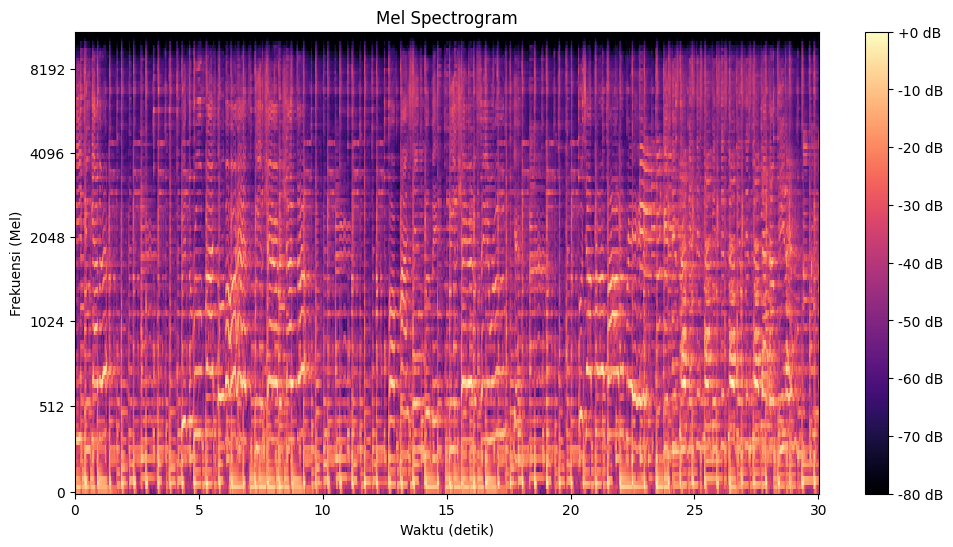

In [ ]:
# Load file audio
file_path = "/content/genre_dataset/genres_original/reggae/reggae.00000.wav"  # Ganti dengan path file audio
yy, sr = librosa.load(file_path, sr=None)

# Compute Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=yy, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot Mel Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Waktu (detik)")
plt.ylabel("Frekuensi (Mel)")
plt.show()

# Ekstraksi Fitur dari Audio (MFCC)

Ekstraksi fitur yang dilakukan pada projek ini yakni:
1. Load Audio
    *   Menggunakan soundfile.read() untuk membaca file audio.
    *   Jika audio stereo, dikonversi ke mono dengan rata-rata kedua channel.

2. Normalisasi Sample Rate
    *   Jika sample rate bukan 22050 Hz, maka audio di-resample.

3. Durasi Tetap (30 detik)
    *   Jika audio kurang dari 30 detik, akan dipadatkan dengan nol (np.pad).
    *   Jika lebih panjang, akan dipotong.

4. Ekstraksi MFCC (Mel-Frequency Cepstral Coefficients)
    *   librosa.feature.mfcc() mengekstrak 13 koefisien MFCC.
    *   Nilai rata-rata MFCC dari seluruh frame digunakan sebagai fitur.





In [ ]:
def extract_features(file_path, max_length=30, sr=22050):
    try:
        # 🔄 Load file audio menggunakan soundfile
        y, sr = sf.read(file_path, dtype="float32")

        # Jika audio stereo, konversi ke mono
        if len(y.shape) > 1:
            y = np.mean(y, axis=1)

        # Normalisasi sample rate jika tidak sesuai
        if sr != 22050:
            y = librosa.resample(y, orig_sr=sr, target_sr=22050)
            sr = 22050

        # ✂️ Potong atau pad file agar berdurasi tetap
        target_length = max_length * sr
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        else:
            y = y[:target_length]

        # 🎵 Ekstraksi MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)  # rata-rata setiap koefisien MFCC

        # 🎶 Ekstraksi Chromagram
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)  # rata-rata setiap bin chroma

        # 🔍 Ekstraksi Spectral Contrast
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_contrast_mean = np.mean(spec_contrast.T, axis=0)  # rata-rata tiap frekuensi

        # Menggabungkan semua fitur menjadi satu vektor
        features = np.concatenate((mfcc_mean, chroma_mean, spec_contrast_mean))

        return features

    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

# Load Dataset & Ekstraksi Fitur

Memuat dataset dan hasil ekstraksi fitur dengan penjelasan singkat sebagai berikut:
1. Iterasi setiap genre dalam dataset.
2. Load setiap file audio dan ekstrak fitur MFCC.
3. Label genre dikonversi menjadi angka sesuai dengan indeks di list GENRES.

In [ ]:
# Load dataset & ekstraksi fitur
X, y = [], []

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)

    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)

        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(GENRES.index(genre))  # Label numerik berdasarkan indeks genre


❌ Error loading /content/genre_dataset/genres_original/jazz/jazz.00054.wav: Error opening '/content/genre_dataset/genres_original/jazz/jazz.00054.wav': Format not recognised.


# Konversi Data ke Format Numpy

Melakukan konversi data ke format numpy, dimana Data X (MFCC) dan y (label genre) dikonversi ke array numpy.

In [ ]:
# Konversi ke numpy array
X = np.array(X)
y = np.array(y)

Menyimpan hasil ekstraksi fitur dengan format CSV

In [ ]:
# Simpan X dan y ke dalam DataFrame
df_Xy = pd.DataFrame(X)  # Simpan fitur
df_Xy['label'] = y        # Tambahkan kolom label

# Simpan ke CSV
df_Xy.to_csv('/content/Xy_dataset.csv', index=False)

print("Dataset X dan y telah disimpan sebagai 'Xy_dataset.csv'")

Dataset X dan y telah disimpan sebagai 'Xy_dataset.csv'


In [ ]:
# Baca kembali dataset
df_check = pd.read_csv('/content/Xy_dataset.csv')

df_check

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,-129.113968,72.119766,-7.765846,49.260910,-32.721973,21.608433,-27.374638,15.002842,-10.258775,12.437438,...,0.285289,0.294219,22.961144,16.314214,20.450671,20.170225,19.725651,19.602934,42.529811,0
1,-227.268860,137.730698,-14.493466,63.555702,5.612641,11.984640,1.885552,-1.863377,-7.620555,-2.447175,...,0.365258,0.191182,16.078663,19.496394,24.151917,21.211439,20.580586,20.623994,30.653466,0
2,-192.693817,111.188164,21.373310,26.392143,-0.648375,23.480881,-25.470800,16.924429,-16.979984,5.790150,...,0.443421,0.217087,34.825052,23.605652,24.297815,22.982242,22.933958,20.723487,40.985236,0
3,-180.148743,131.410782,0.573336,43.165672,14.135556,25.621374,-5.315874,12.034328,-13.538714,-1.094122,...,0.316901,0.349849,21.713525,18.006798,23.458210,22.722123,22.925912,22.008124,37.445094,0
4,-346.886871,139.247955,24.084862,22.264017,18.647840,11.657903,9.017679,6.977828,-2.023301,5.420398,...,0.468546,0.451620,24.612199,18.996922,20.273771,18.677305,18.504408,18.110960,27.149339,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-70.117538,94.181656,-50.328030,46.962898,-16.114254,19.996185,-23.959724,16.344028,-22.188528,14.435193,...,0.580418,0.419805,28.446014,15.212575,18.465376,16.984094,16.818417,17.246567,42.150174,9
995,-55.330608,114.442459,-34.068890,37.984398,-22.331318,18.526556,-18.157928,13.806143,-27.803478,18.161308,...,0.283492,0.246623,16.576773,13.854245,17.333484,17.170830,17.542325,19.450526,42.524637,9
996,-35.399132,73.675453,-20.210777,17.162956,14.951290,10.214682,7.604469,1.598915,4.177347,0.735545,...,0.421704,0.532105,29.114417,14.500691,17.531913,18.516483,19.162657,17.938174,15.055208,9
997,-88.000725,93.537323,-23.228851,48.129993,-21.446268,27.758793,-20.340561,18.754475,-15.226568,16.130507,...,0.557577,0.373639,25.872087,14.776089,18.378704,18.855068,18.548911,18.609807,42.587650,9


# Pembagian Data Training & Testing

Melakukan pembagian data pelatihan dan pengetesan dengan penjelasan sebagai berikut:
1. Data dibagi menjadi:
    *   80% training (X_train, y_train)
    *   20% testing (X_test, y_test)

2. Parameter stratify=y memastikan proporsi genre tetap seimbang di training dan testing.

In [ ]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisasi Data

Melakukan normalisasi data dengan penjelasan sebagai berikut:
1. Standardisasi fitur menggunakan StandardScaler().
2. Mean dari fitur menjadi 0, standar deviasi menjadi 1.

In [ ]:
# Normalisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Pelatihan dan Prediksi

## Training Model SVM

Melatih model menggunakan *Support Vector Machine* (SVM), dengan penjelasan setiap bagiannya adalah sebagai berikut:
1. SVM (Support Vector Machine) dengan kernel RBF digunakan untuk klasifikasi.
2. C=10 → Mengontrol kompleksitas model.
3. gamma='scale' → Menentukan seberapa jauh pengaruh satu contoh pelatihan.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Tentukan parameter grid untuk SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Inisialisasi model SVM (tanpa hyperparameter khusus)
svm = SVC()

# Inisialisasi GridSearchCV dengan 5-fold cross validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Melatih model menggunakan Grid Search CV pada data training
grid_search.fit(X_train, y_train)

# Cetak parameter terbaik yang ditemukan
print("Parameter terbaik:", grid_search.best_params_)
print("Akurasi terbaik:", grid_search.best_score_)

# Menggunakan model terbaik untuk prediksi atau evaluasi lebih lanjut
best_model = grid_search.best_estimator_


Parameter terbaik: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Akurasi terbaik: 0.6759040880503144


## Prediksi & Evaluasi Model

Pada langkah ini, model melakukan prediksi genre untuk dataset testing.

In [ ]:
# Prediksi & Evaluasi
y_pred = best_model.predict(X_test)

# Evaluasi Model

## Evaluasi Akurasi

Melakukan evaluasi model dengan penjelasan sebagai berikut:
1. Menghitung akurasi model menggunakan accuracy_score().
2. Menampilkan laporan klasifikasi (precision, recall, f1-score) per genre.

In [ ]:
# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi Model: {accuracy:.4f}')
print(classification_report(y_test, y_pred, target_names=GENRES))

Akurasi Model: 0.7450
              precision    recall  f1-score   support

       blues       0.85      0.85      0.85        20
   classical       0.83      0.95      0.88        20
     country       0.77      0.50      0.61        20
       disco       0.68      0.75      0.71        20
      hiphop       0.70      0.70      0.70        20
        jazz       0.65      0.85      0.74        20
       metal       1.00      0.70      0.82        20
         pop       0.81      0.85      0.83        20
      reggae       0.59      0.65      0.62        20
        rock       0.68      0.65      0.67        20

    accuracy                           0.74       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.76      0.74      0.74       200



## Confusion Matrix

Selain menghitung metrik evaluasi, performa model juga dinilai dari *Confusion Matrix*. Adapun penjelasan singkatnya adalah sebagai berikut:
1. Membuat confusion matrix untuk melihat kesalahan prediksi.
2. Heatmap visualisasi menggunakan Seaborn.

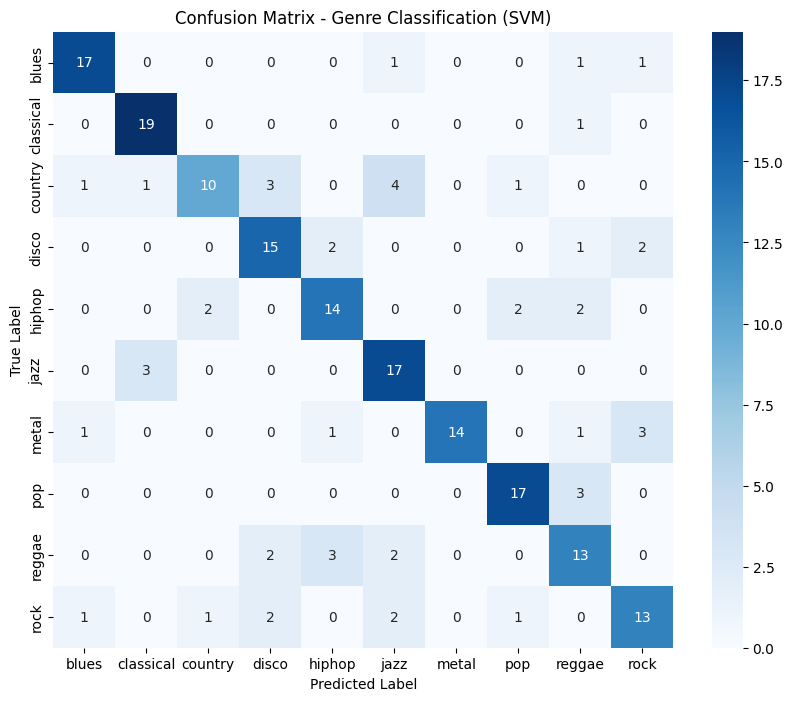

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=GENRES, yticklabels=GENRES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Genre Classification (SVM)")
plt.show()

# Peningkatan Performa Model

----

# 1. Eksperimen Peningkatan Model
Lakukan minimal satu eksperimen untuk meningkatkan performa model. Anda dapat mencoba metode berikut atau metode lain yang sesuai:

* Menambahkan fitur baru (contoh: MFCC + Chromagram + Spectral Contrast)
* Melakukan normalisasi atau scaling data
* Menggunakan teknik hyperparameter tuning (contoh: Grid Search CV pada SVM)
* Mengubah arsitektur model (contoh: dari SVM ke CNN)

👉 Berikan kode eksperimen yang dilakukan serta penjelasan perubahan yang dibuat.

**JAWABAN**

Berikut adalah kode eksperimen yang saya buat :

In [ ]:
def extract_features(file_path, max_length=30, sr=22050):
    try:
        # 🔄 Load file audio menggunakan soundfile
        y, sr = sf.read(file_path, dtype="float32")

        # Jika audio stereo, konversi ke mono
        if len(y.shape) > 1:
            y = np.mean(y, axis=1)

        # Normalisasi sample rate jika tidak sesuai
        if sr != 22050:
            y = librosa.resample(y, orig_sr=sr, target_sr=22050)
            sr = 22050

        # ✂️ Potong atau pad file agar berdurasi tetap
        target_length = max_length * sr
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        else:
            y = y[:target_length]

        # 🎵 Ekstraksi MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)  # rata-rata setiap koefisien MFCC

        # 🎶 Ekstraksi Chromagram
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)  # rata-rata setiap bin chroma

        # 🔍 Ekstraksi Spectral Contrast
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_contrast_mean = np.mean(spec_contrast.T, axis=0)  # rata-rata tiap frekuensi

        # Menggabungkan semua fitur menjadi satu vektor
        features = np.concatenate((mfcc_mean, chroma_mean, spec_contrast_mean))

        return features

    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

kode yang saya berikan adalah kode untuk menambahkan fitur baru berupa **MFCC + Chromagram + Spectral Contrast** . disini saya melakukan perubahan dengan menambahkan chromagram untuk menganalisis energi tiap kelas nada musik , kemudian saya juga menambahkan spectral contrast untuk mengukur perbedaan antara puncak dan Lembah spektrum frekuensi lalu menggabungkan semua fitur dengan hstack dalam satu array vektor . selanjutnya saya juga mengombinasikan eksperimen pada poin selanjutnya pada model svm dilakukan **hyperparameter tuning dengan GridSearchCV** . berikut perubahan kode yang saya buat :

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Tentukan parameter grid untuk SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Inisialisasi model SVM (tanpa hyperparameter khusus)
svm = SVC()

# Inisialisasi GridSearchCV dengan 5-fold cross validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Melatih model menggunakan Grid Search CV pada data training
grid_search.fit(X_train, y_train)

# Cetak parameter terbaik yang ditemukan
print("Parameter terbaik:", grid_search.best_params_)
print("Akurasi terbaik:", grid_search.best_score_)

# Menggunakan model terbaik untuk prediksi atau evaluasi lebih lanjut
best_model = grid_search.best_estimator_

Parameter terbaik: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Akurasi terbaik: 0.6759040880503144


# 2. Analisis Peningkatan Performa
Setelah melakukan eksperimen, lakukan analisis terhadap hasilnya:
* Bandingkan akurasi sebelum dan sesudah eksperimen.
* Jelaskan mengapa perubahan yang dilakukan dapat meningkatkan performa
model.

👉 Gunakan matrik evaluasi seperti akurasi, confusion matrix, atau lainnya untuk
mendukung analisis.

**JAWABAN**

setelah saya melakukan eksperimen dengan mengubah dua komponen kode yaitu menambahkan feature extraction dengan MFCC + Chromagram + Spectral Contrast lalu melakukan GridSearchCV pada SVM , saya mendapatkan akurasi sebesar 0.7475 yang lebih baik dari akurasi sebelumnya 0.65 . hal ini bisa dilihat pada hasil berikut :

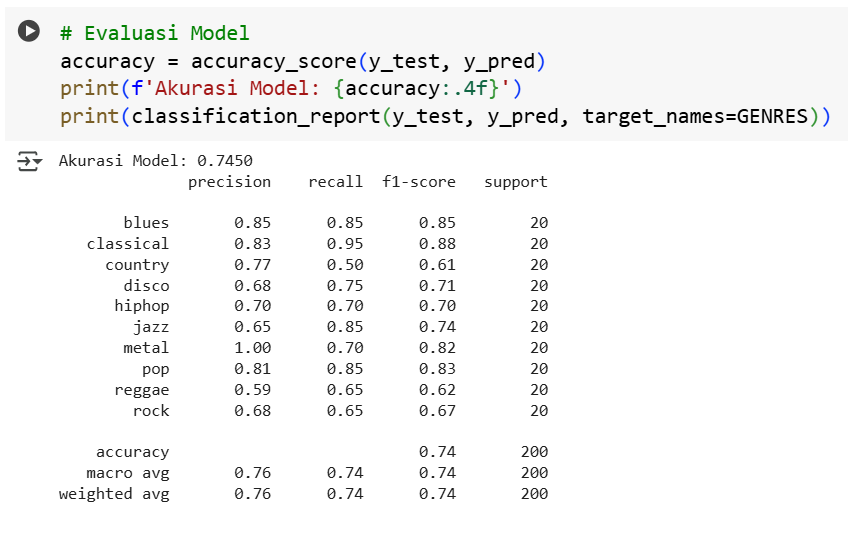

dengan confusion matrix sebagai berikut :    

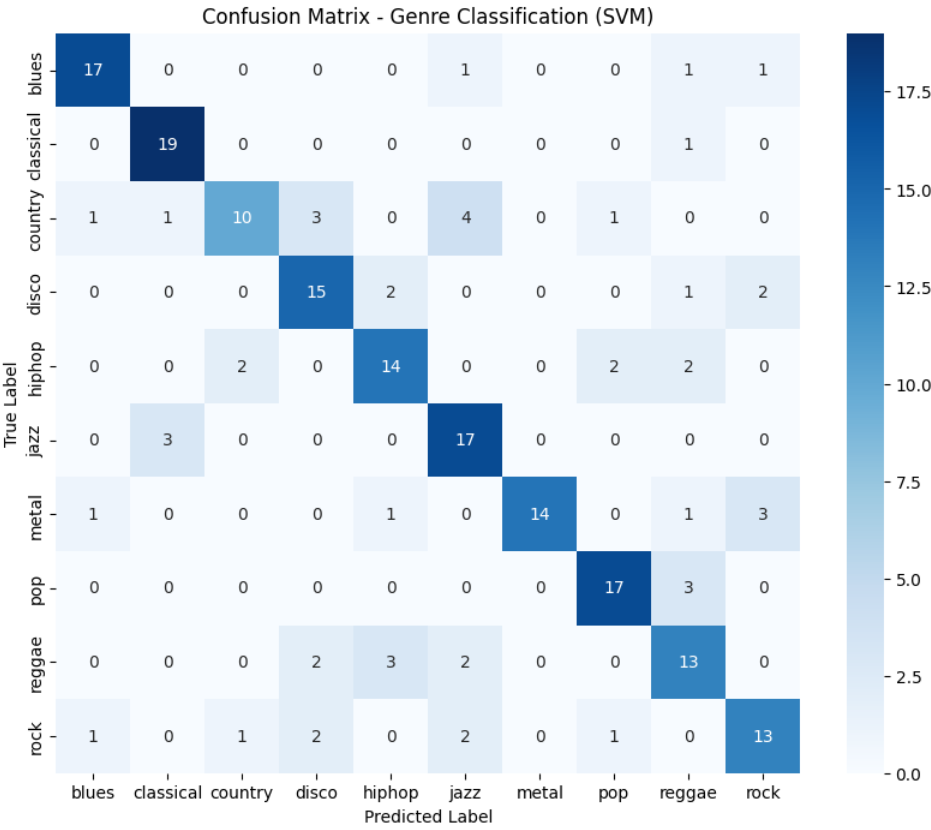

Setelah dilakukan perbaikan dengan menambahkan fitur **MFCC + Chromagram + Spectral Contrast** serta optimasi hyperparameter menggunakan **Grid Search**, akurasi model meningkat dari **67%** menjadi **74,5%**. Confusion matrix menunjukkan peningkatan jumlah prediksi benar pada beberapa genre seperti *blues* (14 → 17), *rock* (9 → 13), dan *reggae* (2 → 7), serta mempertahankan performa tinggi pada genre *classical* dan *metal*. Penambahan fitur spektral ini membantu model membedakan genre yang memiliki kesamaan ritme tetapi berbeda dalam karakter nada dan harmoni, sementara optimasi parameter pada **SVM** meningkatkan generalisasi model, mengurangi kesalahan klasifikasi antar genre yang mirip. Hasil ini menunjukkan bahwa dengan kombinasi fitur yang lebih informatif dan parameter yang dioptimalkan, model mampu mengenali pola unik dari setiap genre dengan lebih akurat.

# 3. Eksperimen Tambahan (Opsional, Nilai Tambahan)
Jika ingin mendapatkan nilai tambahan, lakukan eksperimen tambahan dengan metode lain,
misalnya:
* Mencoba model yang berbeda dan membandingkan hasilnya.
* Menggunakan teknik augmentasi data untuk meningkatkan performa.
* Menganalisis keandalan model terhadap berbagai jenis data input.
* Untuk mendapatkan nilai yang optimal usahakan akurasi yang didapatkan diatas 80% dengan pembahasan yang lengkap

👉 Sertakan kode, hasil evaluasi, dan analisis performa dari eksperimen tambahan ini.

**JAWABAN**

saya telah menjelaskan semua perubahan yang saya lakukan untuk mencapai akurasi 82,5% di notebook lain

